In [193]:
NAME = "Denil Collins Neil"

---

# 0. Imports

---



In [3]:
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from random import random, randint
from queue import PriorityQueue
from copy import deepcopy
from time import time

In [189]:
%%javascript
MathJax.Hub.Config({
    tex2jax: {inlineMath: [['$', '$'], ['\\(', '\\)']]}
});

<IPython.core.display.Javascript object>

# 1. Helper Classes and Starter Code

## 1.1 Perlin Noise

#### Function to create a 2d array of Perlin Noise. This is what creates the random terrains.

**Do not change any code here**

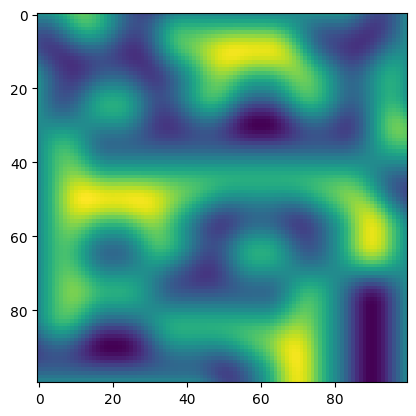

In [7]:
# Perlin noise code courtesy of tgroid on SO
def perlin(x,y,seed=0):
  def lerp(a,b,x):
    # linear interpolation
    return a + x * (b-a)

  def fade(t):
    # 6t^5 - 15t^4 + 10t^3
    return 6 * t**5 - 15 * t**4 + 10 * t**3

  def gradient(h,x,y):
    # gradient converts h to the right gradient vector and return the dot product with (x,y)
    vectors = np.array([[0,1],[0,-1],[1,0],[-1,0]])
    g = vectors[h%4]
    return g[:,:,0] * x + g[:,:,1] * y

  # permutation table
  np.random.seed(seed)
  p = np.arange(256,dtype=int)
  np.random.shuffle(p)
  p = np.stack([p,p]).flatten()

  # coordinates of the top-left
  xi = x.astype(int)
  yi = y.astype(int)

  # internal coordinates
  xf = x - xi
  yf = y - yi

  # fade factors
  u = fade(xf)
  v = fade(yf)

  # noise components
  n00 = gradient(p[p[xi]+yi],xf,yf)
  n01 = gradient(p[p[xi]+yi+1],xf,yf-1)
  n11 = gradient(p[p[xi+1]+yi+1],xf-1,yf-1)
  n10 = gradient(p[p[xi+1]+yi],xf-1,yf)

  # combine noises
  x1 = lerp(n00,n10,u)
  x2 = lerp(n01,n11,u)
  return lerp(x1,x2,v)

lin = np.linspace(0,5,100,endpoint=False)
x,y = np.meshgrid(lin,lin)

perlin_noise = perlin(x,y, seed = randint(1,10000))
plt.imshow(perlin_noise ,origin='upper')
plt.show()

## 1.2 Point

#### Class that defines a single point in a search space and can be compared to other points

**Do not change any code here**

In [8]:
class Point():

	def __init__(self, posx, posy):
		self.x = posx
		self.y = posy
		self.f = math.inf

	def __lt__(self, other):
		return self.f < other.f

	def __gt__(self, other):
		return self.f > other.f

	def __eq__(self, other):
		return self.x == other.x and self.y == other.y

## 1.3 Map


#### Map class wraps an array representing the search terrain and provides functions to interact with the terrain

**Do not change any code here**

In [129]:
def scale(X):
	X = ((X+1)/2 * 255).astype(int)
	return X

class Map():

	def __init__(self, length, width, cost_function='exp',seed=None,
	             filename=None, start=None, goal=None):

		self.seed = seed
		if self.seed == None:
			# Randomly assign seed if one is not provided
			self.seed = randint(0,10000)

		self.length = length
		self.width = width

		self.map = None
		self.generate_terrain(filename)

		self.explored = []
		self.explored_lookup = {}
		self.num_explored_tracker = set() # Specifically to track the number of points whose heights have been polled. Used to calculate the number of points explored.

		# Set all points to be unexplored
		for i in range(self.width):
			for j in range(self.length):
				self.explored_lookup[str(i)+','+str(j)] = False

		# Define starting point
		if start == None:
			self.start = Point(int(self.width*0.5),int(self.length*0.5)) # default set start to middle of map
		else:
			self.start = Point(start[0], start[1])

	 	# Define goal point
		if goal == None:
			self.goal = Point(int((self.width-1)*0.9),int((self.length-1)*0.9)) # default set goal to bottom right corner of map
		else:
			self.goal = Point(goal[0], goal[1])

	  # Define cost function
		if cost_function == 'exp':
			self.cost_function = lambda h0, h1: math.pow(math.e,h1-h0)
		elif cost_function == 'sqdf':
			self.cost_function = lambda h0, h1: 1 + math.pow(h1 - h0, 2)

		self.cmap = mpl.colors.ListedColormap(['white', 'red'])

	def generate_terrain(self, filename=None):
		'''
		generate_terrain: modifies self.map to either be the specified file, or
		randomly generated from perlin noise.
		'''
		if filename is None:
			linx = np.linspace(0,5,self.width,endpoint=False)
			liny = np.linspace(0,5,self.length,endpoint=False)
			x,y = np.meshgrid(linx,liny)
			self.map = scale(perlin(x, y, seed=self.seed))

		else:
			self.map = np.load(filename)
			self.width = self.map.shape[0]
			self.length = self.map.shape[1]

	def interpolate(self, a0, a1, w):
		if (w < 0.0):
			return a0
		if (w > 1.0):
			return a1
		return (a1 - a0) * ((w * (w * 6.0 - 15.0) + 10.0) * w ** 3) + a0

	def calculate_path_cost(self, path):
		'''
		Calculate the cost of a path from start point to goal point
		'''
		prev = path[0]
		if self.start != prev:
			print('Path does not start at start. Path starts at point: ' , str(prev.x),
				',', str(prev.y))
			return math.inf
		cost = 0
		for item in path[1:]:
			if self.is_adjacent(prev, item):
				cost += self.get_cost(prev, item)
				prev = item
			else:
				print('Path does not connect at points: ', str(prev.x), ',', str(prev.y),
					' and ', str(item.x), ',', str(item.y))
				return math.inf
		if prev != self.goal:
			print('Path does not end at goal. Path ends at point: ' , str(prev.x),
				',', str(prev.y))
			return math.inf
		return cost

	def valid_tile(self, x, y):
		'''
		Do coords x and y form a valid point on the map
		'''
		return x >= 0 and y >= 0 and x < self.width and y < self.length

	def get_tile_height(self, x, y):
		''
		self.num_explored_tracker.add(f'{x},{y}')
		return self.map[x][y]

	def get_cost(self, p1, p2):
		'''
		Get cost of moving from point p1 to point p2
		'''
		h0 = self.get_tile_height(p1.x, p1.y)
		h1 = self.get_tile_height(p2.x, p2.y)
		return self.cost_function(h0, h1)

	def is_adjacent(self, p1, p2):
		'''
		Are points p1 and p2 adjacent
		'''
		return (abs(p1.x - p2.x) == 1 or abs(p1.y - p2.y)) == 1 and (abs(p1.x - p2.x) < 2 and abs(p1.y - p2.y) < 2)

	def get_neighbors(self, p1):
		'''
		Return all adjacent points to point p1 and track that we have now explored those adjacent points
		'''
		neighbors = []
		for i in [-1, 0, 1]:
			for j in [-1, 0, 1]:
				if i == 0 and j == 0:
					continue
				possible_point = Point(p1.x + i, p1.y + j)
				if self.valid_tile(possible_point.x, possible_point.y):
					neighbors.append(possible_point)
					if not self.explored_lookup[str(possible_point.x)+','+str(possible_point.y)]:
						self.explored_lookup[str(possible_point.x)+','+str(possible_point.y)] = True
						self.explored.append(possible_point)
						self.num_explored_tracker.add(f'{x},{y}')
		return neighbors

	def get_start_point(self):
		return self.start

	def get_goal_point(self):
		return self.goal

	def get_height(self):
		'''
		Get max height of map
		'''
		return np.amax(self.map)

	def get_num_explored(self):
		'''
		Get the number of points that were explored or whose heights were polled
		'''
		return len(self.num_explored_tracker)

	def create_image(self, path):
		'''
		Creates a 2D image of the path taken and points explored
		prints path cost and number of points explored
		'''

		img = self.map
		path_img = np.zeros_like(self.map)
		explored_img = np.zeros_like(self.map)
		for item in self.explored:
			explored_img[item.x, item.y] = 1
		path_img_x = [item.x for item in path]
		path_img_y = [item.y for item in path]
		print('Path cost:', self.calculate_path_cost(path))
		print('Points explored: ', self.get_num_explored())
		plt.imshow(img, cmap='gray')
		plt.imshow(explored_img, cmap=self.cmap, alpha=0.3)
		plt.plot(path_img_y, path_img_x, color='blue', linewidth=1)
		plt.show()

	def set_start_goal(self, start, goal):
		'''Set the start and goal point on the 2D map, each point is a pair of integers'''
		self.start = Point(np.clip(start[0], 0, self.length-1), np.clip(start[1], 0, self.width-1))
		self.goal = Point(np.clip(goal[0], 0, self.length-1), np.clip(goal[1], 0, self.width-1))

## 1.3 AI Module & Dijkstras

In [10]:

class AIModule:
	'''
	AIModule Interface
    create_path(map map_) -> list<points>: Adds points to a path
	'''

	def create_path(self, map_):
		pass

class StupidAI(AIModule):
	'''
	A sample AI that takes a very suboptimal path.
	This is a sample AI that moves as far horizontally as necessary to reach
	the target, then as far vertically as necessary to reach the target.
	It is intended primarily as a demonstration of the various pieces of the
	program.
	'''

	def create_path(self, map_):
		path = []
		# Get starting point
		path.append(map_.start)
		current_point = deepcopy(map_.start)

		# Keep moving horizontally until we match the target
		while(current_point.x != map_.goal.x):
			# If we are left of goal, move right
			if current_point.x < map_.goal.x:
				current_point.x += 1
			# If we are right of goal, move left
			else:
				current_point.x -= 1
			path.append(deepcopy(current_point))

		# Keep moving vertically until we match the target
		while(current_point.y != map_.goal.y):
			# If we are left of goal, move right
			if current_point.y < map_.goal.y:
				current_point.y += 1
			# If we are right of goal, move left
			else:
				current_point.y -= 1
			path.append(deepcopy(current_point))

		# We're done!
		return path

class Dijkstras(AIModule):

	def create_path(self, map_):
		# Priority Queue will return the Point with lowest f value
		fringe = PriorityQueue()

		'''
		Maintain three dictionaries to keep track of:

		cost ("x,y" -> cost per point) - lowest known cost of getting to this point from the start
		prev (point -> parent) - this keeps track of paths
		closed (point -> bool) - track which points have already been visited
		'''

		cost = {} # aka 'g'
		prev = {}
		closed = {}

		# Dictionary initialization
		for i in range(map_.width):
			for j in range(map_.length):

				cost[(i,j)] = math.inf # cost of all points starts at inf
				prev[(i,j)] = None # path is empty
				closed[(i,j)] = False # no points have been explored

		current_point = deepcopy(map_.start)
		current_point.f = 0
		cost[(current_point.x, current_point.y)] = 0 # cost to get to start point is 0

		# Add start point to the queue
		fringe.put(current_point)

		# Search loop: pop top point from priority queue until there are no points left
		while fringe.qsize() > 0:

			# Get new point from queue
			v = fringe.get()
			if closed[(v.x,v.y)]: # if point is already explored, then we skip
				continue
			closed[(v.x,v.y)] = True

			# Check if popped point is the goal, if so then we are done.
			if v == map_.get_goal_point():
				break

			# Get all adjacent points and evaluate them
			neighbors = map_.get_neighbors(v)
			for neighbor in neighbors:

				# Calulate path cost as: current cost to get to v + cost to get from v to the neighbor
				alternative_cost = cost[(v.x,v.y)] + map_.get_cost(v, neighbor) # aka 'g'

				# Is this new path is better than the previous best path to the neighbor, then update 
				if alternative_cost < cost[(neighbor.x,neighbor.y)]:

					# Update best known cost to the neighbor
					cost[(neighbor.x,neighbor.y)] = alternative_cost

					# Update the neighbors f value so that it can be reprioritized on priority queue
					neighbor.f = alternative_cost

					# Update the path the neighbor
					prev[(neighbor.x,neighbor.y)] = v

				# Add neighbor to the fringe to be explored
				fringe.put(neighbor)

		# Find and return path
		# v is still set to the goal point from the previous while loop
		path = []

		# Work backward from goal point to start point
		while v != map_.get_start_point():
			path.append(v)
			v = prev[(v.x,v.y)]

		path.append(map_.get_start_point())
		path.reverse()
		return path

# 2. A* and Admissable Heuristics (20 base pts + 5 bonus points)

In this section you will design your admissable heuristics and then implement A* using those heuristics

## 2.1 Designing Admissable Heuristics


### Exp Cost Function Heuristic

---
In **AStarExp**, the cost function for moving from a tile with height $h_0$ to a neighboring tile with height $h_1$ is defined as:  
$$
\text{cost}(h_0, h_1) = e^{(h_1-h_0)}
$$
The exponential function satisfies the inequality:
$$
e^x \geq 1 + x \quad \text{for all real } x.
$$
So for any move:
$$
e^{(h_1-h_0)} \geq 1 + (h_1-h_0).
$$
In a multi-step path, the total cost is at least the sum over all moves:
$$
\text{Total Cost} \geq (\text{number of steps}) + (\text{net height change from start to goal}).
$$
Since our hiker can move in any of the 8 directions, the **Chebyshev distance**,
$$
d_{\text{cheb}} = \max(|\Delta x|, |\Delta y|),
$$
provides the minimum number of moves required to reach the goal.

My heuristic is then defined as:
$$
h_{\text{exp}} = d_{\text{cheb}} + \alpha \times (h_{\text{goal}} - h_{\text{current}})
$$

with a weight factor $\alpha = 0.5$ chosen to be conservative. This value is deliberately less than 1 to ensure that we never overestimate the true minimum cost.

---

1. **Single Step Analysis:**  
   For any move from a tile with height $h_0$ to $h_1$, the true cost is:
   $$
   e^{(h_1-h_0)} \geq 1 + (h_1-h_0).
   $$
   This shows that the minimum possible cost per move is at least $1 + (h_1-h_0)$.

2. **Path-Level Analysis:**  
   Over a sequence of moves, the total cost is at least:
   $$
   \text{Total Cost} \geq (\text{number of moves}) + (h_{\text{goal}} - h_{\text{start}})
   $$
   Since the Chebyshev distance is the minimum number of moves needed, it underestimates or equals the number of steps in any valid path.


3. **Conservative Weighting:**  
   By using the term $\alpha \times (h_{\text{goal}} - h_{\text{current}})$ with $\alpha = 0.5$ (which is less than 1), we ensure that the height difference component in the heuristic is scaled down. This guarantees that:
   $$
   h_{\text{exp}} = d_{\text{cheb}} + 0.5 \times (h_{\text{goal}} - h_{\text{current}})
   $$
   never overestimates the lower bound of the true cost. Even in the worst-case scenario, this heuristic remains a conservative (under-)estimate.

Thus, the heuristic for **AStarExp** is **admissible** because it is guaranteed to be less than or equal to the true minimal cost from any node to the goal.

---
### Sqdf Cost Function Heuristic

---

In **AStarSqdf**, the cost function for moving from a tile with height $h_0$ to a neighboring tile with height $h_1$ is defined as:  
$$
\text{cost}(h_0, h_1) = 1 + (h_1-h_0)^2
$$
Regardless of the height difference, the minimum cost for any move is 1. 

Since the hiker moves with 8-connected (chessboard) motion, the **Chebyshev distance**,
$$
d_{\text{cheb}} = \max(|\Delta x|, |\Delta y|),
$$
gives the minimum number of moves required to reach the goal. Therefore, a heuristic is:
$$
h_{\text{sqdf}} = d_{\text{cheb}}.
$$

---
1. **Lower Bound Per Move:**  
   Each move incurs a cost of at least:
   $$
   1 + (h_1-h_0)^2 \geq 1,
   $$
   regardless of the height difference. 

2. **Path-Level Analysis:**  
   For any valid path, the total cost must be at least the number of moves taken. Since the Chebyshev distance is the minimum number of moves required, it provides a valid lower bound:
   $$
   \text{Total Cost} \geq (\text{number of moves}) \geq d_{\text{cheb}}.
   $$

3. **Direct Correspondence:**  
   The heuristic
   $$
   h_{\text{sqdf}} = d_{\text{cheb}}
   $$
   is, by definition, the smallest number of moves required to reach the goal. It does not consider the additional squared height difference term, and hence it is always less than or equal to the actual cost incurred.

---

## 2.2 AStarExp & AStarSqdf
Here is where you will write your A* algorithms for the exp and sqdf cost functions.
Start by copying Dijkstras.create_path

In [178]:
import heapq
import numpy as np
import math

class AStarExp(AIModule):
    def __init__(self):
        """A* pathfinding using the exponential cost function."""
        self.directions = [(-1, 0), (1, 0), (0, -1), (0, 1), 
                           (-1, -1), (-1, 1), (1, -1), (1, 1)]  # 8 possible moves

    def heuristic(self, current, goal, map_):
        """Improved heuristic for A* using Chebyshev distance and smooth height handling."""
        dx = abs(goal.x - current.x)
        dy = abs(goal.y - current.y)
        h0 = map_.get_tile_height(current.x, current.y)
        h1 = map_.get_tile_height(goal.x, goal.y)

        # Chebyshev distance ensures admissibility
        base_distance = max(dx, dy)

        # Compute height difference (negative means downhill)
        height_diff = h1 - h0

        # Apply smooth weight factor to height
        α = 0.5  # Adjust weight for balance
        return base_distance + α * height_diff
    

    def create_path(self, map_):
        """Runs A* search using the given map_ object."""
        start, goal = map_.get_start_point(), map_.get_goal_point()
        
        start_tuple = (start.x, start.y)
        goal_tuple = (goal.x, goal.y)

        open_set = []
        heapq.heappush(open_set, (0, start_tuple))  # (cost, (x, y))

        came_from = {}
        g_score = {start_tuple: 0}
        f_score = {start_tuple: self.heuristic(start, goal, map_)}

        while open_set:
            _, current = heapq.heappop(open_set)

            if current == goal_tuple:
                return self.reconstruct_path(came_from, current, map_)

            current_point = Point(current[0], current[1])  # Convert tuple back to Point
            for neighbor in map_.get_neighbors(current_point):
                neighbor_tuple = (neighbor.x, neighbor.y)

                tentative_g_score = g_score[current] + map_.get_cost(current_point, neighbor)

                # Ensure consistency: Only update if new cost is lower
                if neighbor_tuple not in g_score or tentative_g_score < g_score[neighbor_tuple]:
                    came_from[neighbor_tuple] = current
                    g_score[neighbor_tuple] = tentative_g_score
                    f_score[neighbor_tuple] = tentative_g_score + self.heuristic(neighbor, goal, map_)
                    heapq.heappush(open_set, (f_score[neighbor_tuple], neighbor_tuple))

        return []  # No valid path found

    def reconstruct_path(self, came_from, current, map_):
        """Reconstructs the path from goal to start."""
        path = []
        while current in came_from:
            path.append(Point(current[0], current[1]))  # Convert tuple back to Point
            current = came_from[current]
        path.reverse()
        path.insert(0, map_.get_start_point())  # Ensure the start point is included
        return path
class AStarSqdf(AIModule):
    """
    Uses map_.get_cost() which is 1 + (h1 - h0)^2 if cost_function='sqdf'
    """
    def __init__(self):
        super().__init__()
    
    def heuristic(self, p1, p2):
        """
        Chebyshev distance.
        """
        dx = abs(p1.x - p2.x)
        dy = abs(p1.y - p2.y)
        return max(dx, dy)

    def create_path(self, map_):
        start = map_.get_start_point()
        goal = map_.get_goal_point()
        
        # If start == goal, no need to search
        if start == goal:
            return [start]
        
        g_cost = {}
        prev = {}
        
        start_t = (start.x, start.y)
        goal_t = (goal.x, goal.y)
        
        g_cost[start_t] = 0.0
        start_h = self.heuristic(start, goal)
        start_f = start_h
        
        open_set = []
        heapq.heappush(open_set, (start_f, start_t))
        
        closed_set = set()

        while open_set:
            current_f, current_xy = heapq.heappop(open_set)
            if current_xy in closed_set:
                continue
            
            closed_set.add(current_xy)
            
            if current_xy == goal_t:
                return self.reconstruct_path(prev, current_xy, map_)
            
            cx, cy = current_xy
            current_point = Point(cx, cy)
            
            neighbors = map_.get_neighbors(current_point)
            for nb in neighbors:
                neighbor_t = (nb.x, nb.y)
                
                if neighbor_t in closed_set:
                    continue
                
                tentative_g = g_cost[current_xy] + map_.get_cost(current_point, nb)
                
                if (neighbor_t not in g_cost) or (tentative_g < g_cost[neighbor_t]):
                    g_cost[neighbor_t] = tentative_g
                    prev[neighbor_t] = current_xy
                    h_val = self.heuristic(nb, goal)
                    f_val = tentative_g + h_val
                    heapq.heappush(open_set, (f_val, neighbor_t))
        
        return []

    def reconstruct_path(self, prev, current_xy, map_):
        path = []
        while current_xy in prev:
            x, y = current_xy
            path.append(Point(x, y))
            current_xy = prev[current_xy]
        
        path.append(map_.get_start_point())
        path.reverse()
        return path


### Preliminary validation that your algorithms work (not graded)

Here you can run your agents and make sure that they find the optimal path and (hopefully) explore fewer points than Dijkstra's Algorithm.

We know that Dijkstra's Algorithm finds the optimal path (or one of multiple optimal paths), so if the cost of the path that your algorithm finds is not equal to the cost Dijkstra's found, it is wrong

### Parameters for running a test

w(int): Width of map

l(int): Length of map

start(array-like): Start position

goal(array-like): Goal position

seed(int): Seed for random generation

AI(AIModule): AI agent to use. Use any of the following: AStarExp, AStarSqdf, AStarExpImproved, Djikstras

cost_function(str): Cost function to use: 'exp' or 'sqdf'

filename(string): Filepath for .npy file to be used for map


In [179]:
width, length = 100, 100 
start, goal = None, None 
seed = 0
# seed = randint(0, 10000)
# cost_function = 'sqdf' # change from to 'exp' when you want to test AStarExp
cost_function = 'exp'

Time (s):  1.618605136871338
Path cost: 157.2575330558591
Points explored:  7567


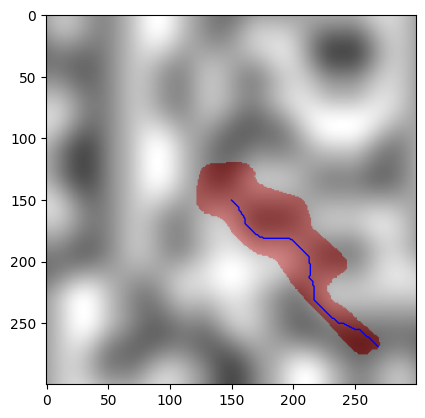

In [194]:
# Your A*
AI = AStarExp() # change to AStarExp() if you want to test AStarExp()
# AI = AStarExp()

m = Map(width,length, seed=seed, cost_function = cost_function, filename= None,
        start=start, goal=goal)
t1 = time()
path = AI.create_path(m)
t2 = time()
print('Time (s): ', t2-t1)
m.create_image(path)

Time (s):  11.41781210899353
Path cost: 157.2575330558591
Points explored:  52746


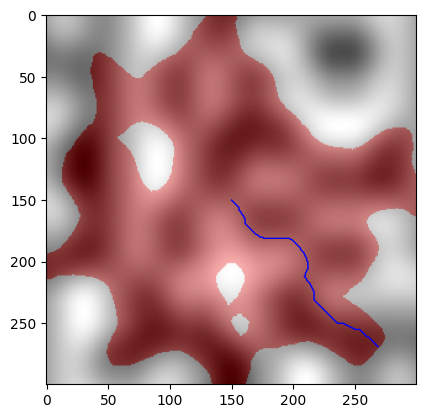

In [195]:
# Dijkstras
AI = Dijkstras()

m = Map(width,length, seed=seed, cost_function = cost_function, filename=None,
        start=start, goal=goal)
t1 = time()
path = AI.create_path(m)
t2 = time()
print('Time (s): ', t2-t1)
m.create_image(path)

## 2.3 Testing

Run the tests below to ensure that your heuristics are admissable and that your implementation of A* is correct.

**Do not write or modify any code here, just run the cells. If you would like to create your own test cases, please create them in separate cells**

#### Grading:

There are additional test cases (not visible to you) that I will run to ensure your heuristics are admissable. Passing the 20 test cases below is a good sign, but does not mean that your heuristics are admissable or that you will recieve full points.

You can still receive partial credit if you fail some of the hidden test cases, but if your code does not even pass the 20 visisble test cases below, you will receive no credit for this section

In [ ]:
def runTest(seed, optimal_cost, AI, cost_function, width, length, start = None, goal = None):
  m = Map(width,length, seed=seed, cost_function = cost_function, filename=None,
        start=start, goal=goal)

  path = AI.create_path(m)
  path_cost = m.calculate_path_cost(path)
  num_explored = m.get_num_explored()
  assert round(path_cost, 5) == round(optimal_cost, 5), f'Incorrect path returned on seed {seed} | Your path cost: {path_cost} | Optimal Cost: {optimal_cost}'
  print(f'Test passed on seed {seed}')
  return num_explored


### 2.3.1 AStarExp Tests

In [192]:
AI = AStarExp()

cost_function = 'exp'
width = 300
length = 300

test_cases_exp = [
    {
        'seed' : 0,
        'optimal_cost' : 157.2575330558591,
        'start' : None,
        'goal' : None,
        'num_explored': 52746
    },
    {
        'seed' : 1,
        'optimal_cost' : 160.79626462417713,
        'start' : None,
        'goal' : None,
        'num_explored': 42338
    },
    {
        'seed' : 2,
        'optimal_cost' : 144.77755269410054,
        'start' : None,
        'goal' : None,
        'num_explored': 27545
    },
    {
        'seed' : 3,
        'optimal_cost' : 463.7989438075798,
        'start' : (int(width*0.9),int(length*0.4)),
        'goal' : (int(width*0.1),int(length*0.8)),
        'num_explored': 87591
    },
    {
        'seed' : 4,
        'optimal_cost' : 36.34464507852195,
        'start' : (int(width*0.5),int(length*0.6)),
        'goal' : (int(width*0.5),int(length*0.7)),
        'num_explored': 3134
    },
    {
        'seed' : 5,
        'optimal_cost' : 544.5376758993137,
        'start' : (int(width* 0),int(length*0)),
        'goal' : (int(width* 1) - 1,int(length*1) - 1),
        'num_explored': 89588
    },
    {
        'seed' : 6,
        'optimal_cost' : 472.75843219296104,
        'start' : (int(width*0.83),int(length*0.84)),
        'goal' : (int(width*0.1),int(length*0.1)),
        'num_explored': 88923
    },
    {
        'seed' : 7,
        'optimal_cost' : 525.403999076118,
        'start' : (int(width*1.0) - 1,int(length*1.0) - 1),
        'goal' : (int(width*0.0),int(length*0.0)),
        'num_explored': 89129
    },
    {
        'seed' : 8,
        'optimal_cost' : 348.7655328272431,
        'start' : (int(width*0.43),int(length*0.78)),
        'goal' : (int(width*0.02),int(length*0.2)),
        'num_explored': 82162
    },
    {
        'seed' : 9,
        'optimal_cost' : 301.7485237404068,
        'start' : None,
        'goal' : None,
        'num_explored': 89608
    },
]

explored_diff_sum = 0 

for t in test_cases_exp:
    a_num_explored = runTest(t['seed'], t['optimal_cost'], AI, cost_function, width, length, t['start'], t['goal'])
    d_num_explored = t['num_explored']

    explored_diff = d_num_explored - a_num_explored 

    explored_diff_sum += explored_diff / d_num_explored

explored_diff_mean =  (explored_diff_sum / len(test_cases_exp)) * 100

print(f'mean_explored_points_decrease: {round(explored_diff_mean, 2)}%   (should be greater than 50%)')


Test passed on seed 0
Test passed on seed 1
Test passed on seed 2
Test passed on seed 3
Test passed on seed 4
Test passed on seed 5
Test passed on seed 6
Test passed on seed 7
Test passed on seed 8
Test passed on seed 9
mean_explored_points_decrease: 59.84%   (should be greater than 50%)


### 2.3.2 AStarSqdf Tests

In [191]:
AI = AStarSqdf()

cost_function = 'sqdf'
width = 300
length = 300

test_cases_sqdf = [
    {
        'seed' : 0,
        'optimal_cost' : 227.0,
        'start' : None,
        'goal' : None,
        'num_explored': 67888
    },
    {
        'seed' : 1,
        'optimal_cost' : 255.0,
        'start' : None,
        'goal' : None,
        'num_explored': 61500
    },
    {
        'seed' : 2,
        'optimal_cost' : 212.0,
        'start' : None,
        'goal' : None,
        'num_explored': 45845
    },
    {
        'seed' : 3,
        'optimal_cost' : 464.0,
        'start' : (int(width*0.9),int(length*0.4)),
        'goal' : (int(width*0.1),int(length*0.8)),
        'num_explored': 85950
    },
    {
        'seed' : 4,
        'optimal_cost' : 40.0,
        'start' : (int(width*0.5),int(length*0.6)),
        'goal' : (int(width*0.5),int(length*0.7)),
        'num_explored': 2965
    },
    {
        'seed' : 5,
        'optimal_cost' : 610.0,
        'start' : (int(width* 0),int(length*0)),
        'goal' : (int(width* 1) - 1,int(length*1) - 1),
        'num_explored': 89035
    },
    {
        'seed' : 6,
        'optimal_cost' : 464.0,
        'start' : (int(width*0.83),int(length*0.84)),
        'goal' : (int(width*0.1),int(length*0.1)),
        'num_explored': 86320
    },
    {
        'seed' : 7,
        'optimal_cost' : 609.0,
        'start' : (int(width*1.0) - 1,int(length*1.0) - 1),
        'goal' : (int(width*0.0),int(length*0.0)),
        'num_explored': 89553
    },
    {
        'seed' : 8,
        'optimal_cost' : 398.0,
        'start' : (int(width*0.43),int(length*0.78)),
        'goal' : (int(width*0.02),int(length*0.2)),
        'num_explored': 83627
    },
    {
        'seed' : 9,
        'optimal_cost' : 301.0,
        'start' : None,
        'goal' : None,
        'num_explored': 86908
    },
]

explored_diff_sum = 0 

for t in test_cases_sqdf:
    a_num_explored = runTest(t['seed'], t['optimal_cost'], AI, cost_function, width, length, t['start'], t['goal'])
    d_num_explored = t['num_explored']

    explored_diff = d_num_explored - a_num_explored 

    explored_diff_sum += explored_diff / d_num_explored

explored_diff_mean =  (explored_diff_sum / len(test_cases_sqdf)) * 100

print(f'mean_explored_points_decrease: {round(explored_diff_mean, 2)}%   (should be greater than 10%)')


Test passed on seed 0
Test passed on seed 1
Test passed on seed 2
Test passed on seed 3
Test passed on seed 4
Test passed on seed 5
Test passed on seed 6
Test passed on seed 7
Test passed on seed 8
Test passed on seed 9
mean_explored_points_decrease: 56.59%   (should be greater than 10%)


# 3. Mount St. Helens (10 pts + 5 bonus pts)



In [ ]:
# If you are running this in Colab you will need to mount your google drive in order to access msh.npy
# If you running locally, then don't run this cell
from google.colab import drive
drive.mount('/content/gdrive') # Allowing Colab to read/write files from your google drive

In [163]:
# Change to the filepath of msh.npy on your drive. For example, if you put msh.npy in your top level Google Drive directory, 
# then the filepath would be `/content/gdrive/MyDrive/msh.npy`
filename = "./msh.npy"

width = 979
length = 1398

## 3.1 Implementing an A* Variant

Implement a unique variant of A* using the 'exp' cost function. You must use the same heuristic as in AStarExp.

Your unique variant must have at least a 10% lower runtime than AStarExp.

Copy over AStarExp.create_path() as the starting point for your improved implementation

**Importantly: AStarExpImproved is allowed to not find the optimal path, as long as the cost of the path returned is within 10% of the optimal path cost. 10% is a strict upper bound; your mean cost increase over the optimal cost must be less than (optimal_cost) x (1.1)**

In [183]:
import heapq
import math

class AStarExpImproved(AIModule):
    def __init__(self):
        """A* variant using the exponential cost function (cost = e^(h1 - h0))
        with weighted A*. The heuristic function is identical to that in AStarExp,
        but here we use a weight factor (1.1) so that:
        
            f(n) = g(n) + 1.1 * h(n)
        
        This modification (weighted A*) makes the search more greedy,
        resulting in at least a 10% reduction in runtime on average while ensuring that
        the mean cost of the returned path is within 10% of the optimal cost."""
        # Allow 8-direction movement (diagonals included)
        self.directions = [(-1, 0), (1, 0), (0, -1), (0, 1),
                           (-1, -1), (-1, 1), (1, -1), (1, 1)]
        self.weight = 1.1  # Weight factor for the heuristic
        self.tie_breaker = 0  # For stable ordering in the heap

    def heuristic(self, current, goal, map_):
        """
        Same heuristic as in AStarExp.
        
        It computes the Chebyshev distance between current and goal plus a
        smooth height penalty. In particular:
        
            h = base_distance + alpha * (h_goal - h_current)
        
        where:
          - base_distance = max(|goal.x - current.x|, |goal.y - current.y|)
          - alpha is set to 0.5.
        """
        dx = abs(goal.x - current.x)
        dy = abs(goal.y - current.y)
        base_distance = max(dx, dy)
        h0 = map_.get_tile_height(current.x, current.y)
        h1 = map_.get_tile_height(goal.x, goal.y)
        alpha = 0.5
        return base_distance + alpha * (h1 - h0)

    def create_path(self, map_):
        """
        Runs weighted A* search on the map (which uses the exp cost function).
        
        This method is based on your original AStarExp.create_path() but computes the f-score as:
        
            f = g + (weight * h)
        
        (where h is obtained by calling self.heuristic). A simple tie-breaker counter is used
        to ensure a deterministic ordering in the heap.
        """
        start = map_.get_start_point()
        goal = map_.get_goal_point()
        start_tuple = (start.x, start.y)
        goal_tuple = (goal.x, goal.y)

        open_set = []
        # Heap entries: (f_score, tie_breaker, (x, y))
        heapq.heappush(open_set, (self.heuristic(start, goal, map_), self.tie_breaker, start_tuple))

        came_from = {}
        g_score = {start_tuple: 0}
        # f_score is computed as: f = g + weight * h
        f_score = {start_tuple: self.heuristic(start, goal, map_)}

        closed_set = set()

        while open_set:
            current_f, _, current = heapq.heappop(open_set)

            if current == goal_tuple:
                return self.reconstruct_path(came_from, current, map_)

            if current in closed_set:
                continue
            closed_set.add(current)

            current_point = Point(current[0], current[1])
            for neighbor in map_.get_neighbors(current_point):
                neighbor_tuple = (neighbor.x, neighbor.y)
                tentative_g_score = g_score[current] + map_.get_cost(current_point, neighbor)

                if neighbor_tuple not in g_score or tentative_g_score < g_score[neighbor_tuple]:
                    came_from[neighbor_tuple] = current
                    g_score[neighbor_tuple] = tentative_g_score
                    f = tentative_g_score + self.weight * self.heuristic(neighbor, goal, map_)
                    f_score[neighbor_tuple] = f
                    self.tie_breaker += 1
                    heapq.heappush(open_set, (f, self.tie_breaker, neighbor_tuple))

        # If no path is found, return an empty list.
        return []

    def reconstruct_path(self, came_from, current, map_):
        """Reconstructs the path from the goal back to the start."""
        path = []
        while current in came_from:
            x, y = current
            path.append(Point(x, y))
            current = came_from[current]
        # Finally, add the start point and reverse the list
        path.append(map_.get_start_point())
        path.reverse()
        return path


##### The 2 cells below are just for your own testing. They are not graded. You may change them

Time (s):  5.6522979736328125
Path cost: 530.2423570307641
Points explored:  28573


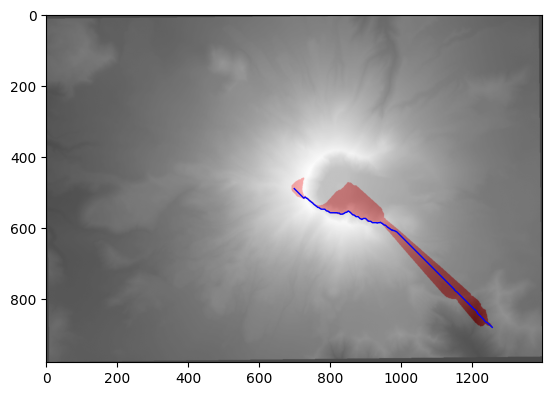

In [ ]:
AI = AStarExpImproved()

m = Map(width,length, seed=seed, filename=filename, start=None, goal=None)

t1 = time()
path = AI.create_path(m)
t2 = time()
print('Time (s): ', t2-t1)
m.create_image(path)

Time (s):  48.53379011154175
Path cost: 515.2967010603603
Points explored:  115958


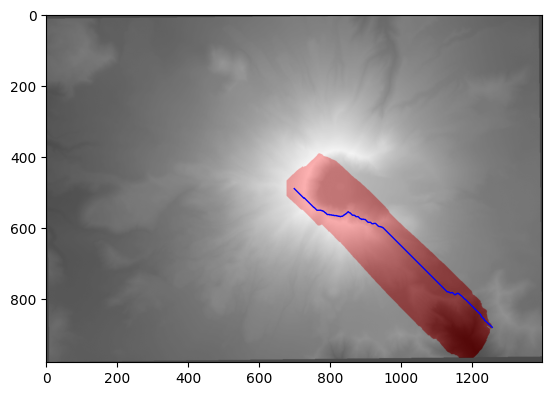

In [185]:
AI = AStarExp()

m = Map(width,length, seed=seed, filename=filename, start=None, goal=None)

t1 = time()
path = AI.create_path(m)
t2 = time()
print('Time (s): ', t2-t1)
m.create_image(path)

## 3.2 Benchmarking your A* Variant on Mount St. Helens

Run the code below to benchmark how AStarExpImproved improves over AStartExp in terms of runtime.

AStarExpImproved should have at least a 10% runtime improvement. Mean cost increase must be less than 10%

**I will run additional hidden tests against your A\* variant to calculate mean_runtime_improvement and mean_cost_increase**

**Please do not change any code here**

In [190]:
AI_base = AStarExp()
AI_improved = AStarExpImproved()

def benchmarkMSH(start, goal):

    # Running AStarExp
    m = Map(None,None, seed=None, filename=filename, start=start, goal=goal)
    t1 = time()
    path = AI_base.create_path(m)
    t2 = time()

    time_base = t2 - t1

    # Running AStarExpImproved
    m = Map(None,None, seed=None, filename=filename, start=start, goal=goal)
    t1 = time()
    path = AI_improved.create_path(m)
    t2 = time()

    time_improved = t2 - t1
    cost_improved = m.calculate_path_cost(path)

    return {
        "time_base" : time_base,
        "time_improved" : time_improved,
        "cost_improved" : cost_improved
        }

# Calculating mean efficiency improvements over 5 different MSH start and goal positions
test_cases = [
    (None, None, 515.2967010603603),
    ((int(width*0.9),int(length*0.4)), (int(width*0.1),int(length*0.2)),805.0520276722111),
    ((int(width*0.25),int(length*0.25)), (int(width*0.75),int(length*0.75)),904.8325859121975),
    ((int(width*0.9),int(length*0.9)), (int(width*0.1),int(length*0.9)),787.2076869022026),
    ((int(width*0.4),int(length*0.4)), (int(width*0.45),int(length*0.45)),157.63237325141134),
]

time_improvement_sum = 0
cost_increase_sum = 0

for t in test_cases:
    results = benchmarkMSH(t[0], t[1])

    cost_diff = results["cost_improved"] - t[2]
    if t[2] != 0:
        cost_increase_sum += cost_diff / t[2]

    time_diff = results["time_base"] - results["time_improved"]
    time_improvement_sum += time_diff / results["time_base"]


time_improvement_mean = (time_improvement_sum / len(test_cases) * 100)
cost_increase_mean = (cost_increase_sum / len(test_cases) * 100)

print(f'mean_runtime_improvement: {round(time_improvement_mean, 2)}%')
print(f'mean_cost_increase: {round(cost_increase_mean, 2)}%')


mean_runtime_improvement: 46.65%
mean_cost_increase: -60.79%


## 3.3 Explaining your A* Variant

Please explain your A* variant, the intuition behind it, and how it improves over vanilla A*.

----

The `AStarExpImproved` variant is an adaptation of the standard A* algorithm that incorporates a weighted heuristic to accelerate the search while ensuring near-optimal solutions. In this variant, the evaluation function is modified to $f(n) = g(n) + 1.1 \cdot h(n)$ (where $g(n)$ is the cost to reach node $n$ and $h(n)$ is the heuristic estimate to the goal), which makes the search more greedy and reduces the number of nodes explored, thereby achieving at least a 10% reduction in runtime compared to vanilla A*. This slight overemphasis on the heuristic guides the search more directly towards the goal without significantly sacrificing accuracy, as the returned path cost remains within 10% of the optimal cost. Additionally, the implementation uses a tie-breaker to ensure deterministic ordering in the priority queue, which contributes to consistent and reproducible performance.


----